# Get the dataset

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('./dataset/BTCUSDT-trades-2025-01.csv')

In [4]:
df.shape

(135946514, 7)

In [5]:
df.columns = [
    "trade_id",
    "price",
    "qty",
    "quote_qty",
    "time",
    "is_buyer_maker",
    "is_best_match"
]


df.head()

,trade_id,price,qty,quote_qty,time,is_buyer_maker,is_best_match
0,4359935387,93576.00,0.00212,198.381120,1735689600074095,True,True
1,4359935388,93576.00,0.00154,144.107040,1735689600074095,True,True
2,4359935389,93576.00,0.00241,225.518160,1735689600091046,True,True
3,4359935390,93576.00,0.00545,509.989200,1735689600091046,True,True
4,4359935391,93576.01,0.00182,170.308338,1735689600266955,False,True


In [6]:
df_subset = df[['price','qty','time']]

In [7]:
df_subset.head()

,price,qty,time
0,93576.00,0.00212,1735689600074095
1,93576.00,0.00154,1735689600074095
2,93576.00,0.00241,1735689600091046
3,93576.00,0.00545,1735689600091046
4,93576.01,0.00182,1735689600266955


In [8]:
df_tick = df_subset.rename(columns={'qty':'volume', 'time':'date_time'})
df_tick['date_time'] = pd.to_datetime(df_tick['date_time'], unit='us')
df_tick = df_tick.reindex(columns=['date_time','price','volume'])
df_tick.head()

,date_time,price,volume
0,2025-01-01 00:00:00.074095,93576.00,0.00212
1,2025-01-01 00:00:00.074095,93576.00,0.00154
2,2025-01-01 00:00:00.091046,93576.00,0.00241
3,2025-01-01 00:00:00.091046,93576.00,0.00545
4,2025-01-01 00:00:00.266955,93576.01,0.00182


In [9]:
df_tick.tail()

,date_time,price,volume
135946509,2025-01-31 23:59:59.923100,102429.56,0.00006
135946510,2025-01-31 23:59:59.923100,102429.56,0.00006
135946511,2025-01-31 23:59:59.923100,102429.56,0.00005
135946512,2025-01-31 23:59:59.923100,102429.56,0.00011
135946513,2025-01-31 23:59:59.923100,102429.56,0.00128


# Volume analysis

In [10]:
import numpy as np
df_daily = df_tick.set_index('date_time')
df_daily['dollar_value'] = df_daily['price'] * df_daily['volume']
df_daily['tick_counts'] = np.ones(len(df_tick))
df_daily = df_daily.resample('D').agg({
    'volume':'sum',
    'price':'first',
    'dollar_value':'sum',
    'tick_counts':'sum'
})
df_daily.head()

,volume,price,dollar_value,tick_counts
date_time,,,,
2025-01-01,10373.32477,93576.00,9.754441e+08,1516555.0
2025-01-02,21970.48948,94591.78,2.118412e+09,3569079.0
2025-01-03,15253.82936,96984.79,1.486611e+09,2851164.0
2025-01-04,8990.05651,98174.17,8.812238e+08,1559982.0
2025-01-05,8095.63723,98220.51,7.939317e+08,1685799.0


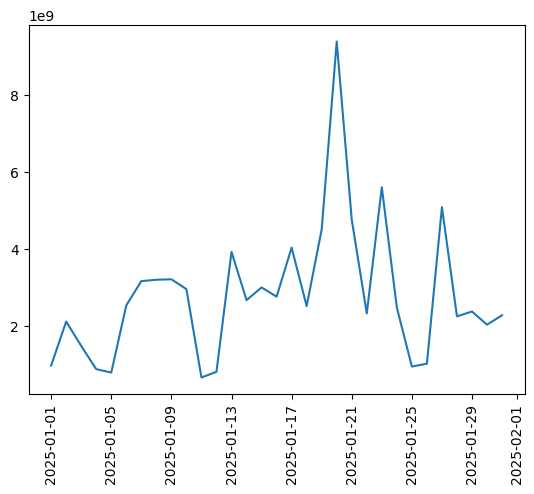

In [11]:
import matplotlib.pyplot as plt

plt.plot(
    df_daily.index,
    df_daily['dollar_value'],
)
plt.xticks(rotation=90)
plt.show()

In [12]:
daily_dollar_volume = df_daily['dollar_value'].mean()
daily_volume = df_daily['volume'].mean()
daily_tick_counts = df_daily['tick_counts'].mean()
daily_dollar_volume, daily_volume, daily_tick_counts

(2803214676.605689, 27888.21732135484, 4385371.419354838)

We'll select the threshold using the formula:

$
\text{threshold} = \frac{\text{Daily volume}}{\text{Desired daily bar frequency}}
$

In [13]:
desired_daily_bar_counts = 96
threshold_dollar = daily_dollar_volume // desired_daily_bar_counts
threshold_volume = daily_volume // desired_daily_bar_counts
threshold_tick = daily_tick_counts // desired_daily_bar_counts

threshold_dollar, threshold_volume, threshold_tick

(29200152.0, 290.0, 45680.0)

In [14]:
from mlfinpy.data_structure import time_bars, standard_bars

In [15]:
dollar = standard_bars.get_dollar_bars(df_tick, threshold=threshold_dollar,
                                        batch_size=1000000, verbose=True)

Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Batch number: 12
Batch number: 13
Batch number: 14
Batch number: 15
Batch number: 16
Batch number: 17
Batch number: 18
Batch number: 19
Batch number: 20
Batch number: 21
Batch number: 22
Batch number: 23
Batch number: 24
Batch number: 25
Batch number: 26
Batch number: 27
Batch number: 28
Batch number: 29
Batch number: 30
Batch number: 31
Batch number: 32
Batch number: 33
Batch number: 34
Batch number: 35
Batch number: 36
Batch number: 37
Batch number: 38
Batch number: 39
Batch number: 40
Batch number: 41
Batch number: 42
Batch number: 43
Batch number: 44
Batch number: 45
Batch number: 46
Batch number: 47
Batch number: 48
Batch number: 49
Batch number: 50
Batch number: 51
Batch number: 52
Batch number: 53
Batch number: 54
Batch number: 55
Batch number: 56
Batch number: 57

In [16]:
# Tick Bars
tick = standard_bars.get_tick_bars(df_tick, threshold=threshold_tick,
                                    batch_size=1000000, verbose=False)

In [17]:
volume = standard_bars.get_volume_bars(df_tick, threshold=threshold_volume,
                                        batch_size=1000000, verbose=False)

In [18]:
dollar.shape, tick.shape, volume.shape

((2974, 10), (2976, 10), (2979, 10))

In [22]:
dollar.head()

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2025-01-01 00:34:50.153086,49440,93576.00,93963.67,93489.03,93882.92,312.31474,140.93429,49440,2.926371e+07
1,2025-01-01 00:58:17.075172,83692,93882.91,94346.52,93836.61,94346.52,310.21286,233.10198,34252,2.920345e+07
2,2025-01-01 01:05:46.248126,111587,94346.57,94509.42,93909.36,93909.36,310.29506,146.12891,27895,2.923487e+07
3,2025-01-01 01:50:22.836761,159549,93909.33,94172.00,93813.50,93813.50,310.81994,145.56140,47962,2.920022e+07
4,2025-01-01 02:52:08.400810,221539,93813.50,94024.06,93578.77,94024.06,311.49943,168.32459,61990,2.920120e+07


In [23]:
volume.head()

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2025-01-01 00:32:32.519130,46273,93576.00,93940.00,93489.03,93940.00,290.05130,128.99844,46273,2.717276e+07
1,2025-01-01 00:57:57.067039,82520,93940.00,94330.59,93836.61,94320.00,290.12551,208.66780,36247,2.729984e+07
2,2025-01-01 01:05:28.341289,109125,94320.00,94509.42,93997.86,94000.00,292.83859,156.24683,26605,2.760956e+07
3,2025-01-01 01:31:56.527742,143810,94000.00,94172.00,93819.60,93947.67,292.12049,130.53835,34685,2.744654e+07
4,2025-01-01 02:16:23.680412,195758,93947.67,93978.18,93578.77,93753.02,290.00191,144.23861,51948,2.719289e+07


In [24]:
tick.head()

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2025-01-01 00:32:17.079847,45680,93576.00,93920.00,93489.03,93920.00,287.02962,126.06876,45680,2.688892e+07
1,2025-01-01 00:59:15.685255,91360,93920.00,94509.42,93836.61,94445.71,462.52080,338.41250,45680,4.357197e+07
2,2025-01-01 01:26:24.346744,137040,94444.02,94444.02,93850.39,93891.44,356.35527,136.69583,45680,3.350755e+07
3,2025-01-01 02:04:20.592846,182720,93891.44,93989.37,93578.77,93762.99,263.24075,107.73407,45680,2.469117e+07
4,2025-01-01 02:59:34.115586,228400,93762.99,94105.12,93674.02,94091.10,249.96017,165.89969,45680,2.346122e+07


In [25]:
dollar.columns

Index(['date_time', 'tick_num', 'open', 'high', 'low', 'close', 'volume',
       'cum_buy_volume', 'cum_ticks', 'cum_dollar_value'],
      dtype='object')

In [18]:
daily_dollar_freq = dollar.set_index('date_time').resample('D').size()
daily_volume_freq = volume.set_index('date_time').resample('D').size()
daily_tick_freq = volume.set_index('date_time').resample('D').size()

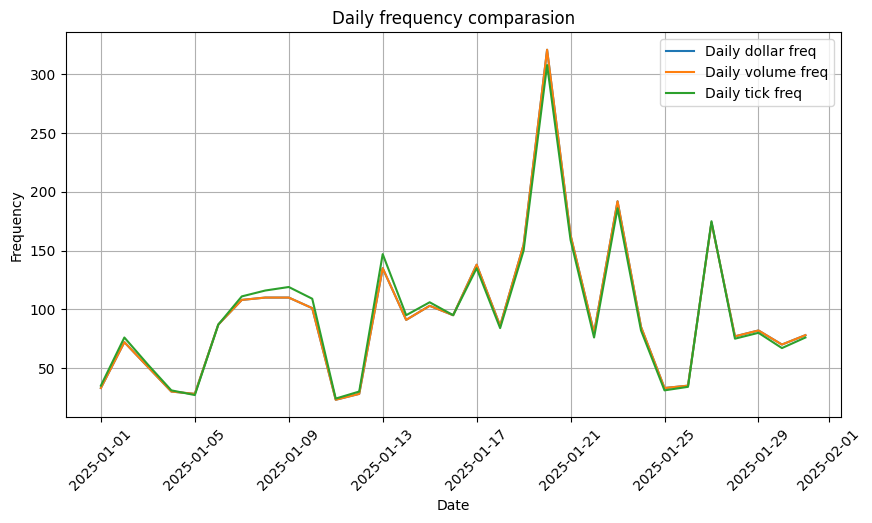

In [30]:
plt.figure(figsize=(10,5))
plt.plot(daily_dollar_freq.index, daily_dollar_freq, label='Daily dollar freq')
plt.plot(daily_volume_freq.index, daily_dollar_freq, label='Daily volume freq')
plt.plot(daily_tick_freq.index, daily_tick_freq, label='Daily tick freq')
plt.title('Daily frequency comparasion')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.xticks(rotation = 45)
plt.show()